# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs using the `dnd_analysis.py` module. 

In [1]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
from pathlib import Path
warnings.filterwarnings('ignore')

import analysis.data_loading as dl
import analysis.basic_metrics as basic

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")


Created plots directory: plots


## Configuration & Campaign Selection {#config}

**Step 1: Choose Your Campaign**
Change the `CAMPAIGN_NAME` below to analyze different campaigns from the dataset. You can also input a list of campaign names.

In [2]:
# Load campaign by name

CAMPAIGN_NAME = ['10391-guardians-of-gridori', 'llm_campaign_10391-guardians-of-gridori_20250730_201553']
dfs = dl.load_campaign_data_by_name(CAMPAIGN_NAME)
df1 = dfs[str(CAMPAIGN_NAME[0])]
df2 = dfs[str(CAMPAIGN_NAME[1])]


print(f"\n📊 DATAFRAMES CREATED WITH INTEGRATED CLASSIFICATION")
df_list = list(dfs.values())
for i in range(len(df_list)):
    df = df_list[i]
    print(f"Campaign: {CAMPAIGN_NAME[i]}")
    print(f"Messages loaded: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique players: {df['player'].nunique()}")
    print(f"Unique characters: {df['character'].nunique()}")
    print(f"✨ Automatic classification includes:")
    print(f"   - Message types: {df['message_type'].value_counts().to_dict()}")
    print(f"   - Primary labels: {df['primary_label'].value_counts().to_dict()}")
    print(f"   - Dice rolls detected: {df['has_dice_roll'].sum()} posts")
    print('\n')


📊 DATAFRAMES CREATED WITH INTEGRATED CLASSIFICATION
Campaign: 10391-guardians-of-gridori
Messages loaded: 216
Date range: 2017-12-16 13:43:31 to 2018-01-30 23:59:13
Unique players: 6
Unique characters: 5
✨ Automatic classification includes:
   - Message types: {'action': 114, 'dialogue': 59, 'narrative': 43}
   - Primary labels: {'in-character': 167, 'out-of-character': 36, 'unlabeled': 7, 'mixed': 6}
   - Dice rolls detected: 13 posts


Campaign: llm_campaign_10391-guardians-of-gridori_20250730_201553
Messages loaded: 151
Date range: 2017-12-16 13:43:31 to 2025-07-30 20:13:07.913979
Unique players: 5
Unique characters: 5
✨ Automatic classification includes:
   - Message types: {'action': 97, 'dialogue': 54}
   - Primary labels: {'in-character': 150, 'out-of-character': 1}
   - Dice rolls detected: 4 posts




In [5]:
for i in range(len(df_list)):
    df = df_list[i]

    print(f"Campaign: {CAMPAIGN_NAME[i]}")
    # Data validation and overview
    print("=== DATA VALIDATION ===")
    print(f"Total messages: {len(df)}")
    print(f"Missing dates: {df['date'].isna().sum()}")
    print(f"Missing players: {df['player'].isna().sum()}")
    print(f"Missing characters: {df['character'].isna().sum()}")
    print(f"Missing text: {df['text'].isna().sum()}")

    print("\n=== BASIC STATISTICS ===")
    print(f"Average words per post: {df['word_count'].mean():.1f}")
    print(f"Posts with dice rolls: {df['has_dice_roll'].sum()} ({df['has_dice_roll'].mean()*100:.1f}%)")
    print(f"Posts in combat: {df['in_combat'].sum()} ({df['in_combat'].mean()*100:.1f}%)")

    print("\n=== MESSAGE TYPE DISTRIBUTION ===")
    print(df['message_type'].value_counts())

    print("\n=== TOP PLAYERS BY POST COUNT ===")
    print(df['player'].value_counts().head(10))
    print('\n')

Campaign: 10391-guardians-of-gridori
=== DATA VALIDATION ===
Total messages: 216
Missing dates: 0
Missing players: 0
Missing characters: 1
Missing text: 0

=== BASIC STATISTICS ===
Average words per post: 93.8
Posts with dice rolls: 13 (6.0%)
Posts in combat: 32 (14.8%)

=== MESSAGE TYPE DISTRIBUTION ===
message_type
action       114
dialogue      59
narrative     43
Name: count, dtype: int64

=== TOP PLAYERS BY POST COUNT ===
player
LightSpeed       53
AmazingAmazon    44
JacWalke         42
ShyVideoGamer    41
Finny            35
fromshus          1
Name: count, dtype: int64


Campaign: llm_campaign_10391-guardians-of-gridori_20250730_201553
=== DATA VALIDATION ===
Total messages: 151
Missing dates: 0
Missing players: 0
Missing characters: 0
Missing text: 0

=== BASIC STATISTICS ===
Average words per post: 207.0
Posts with dice rolls: 4 (2.6%)
Posts in combat: 0 (0.0%)

=== MESSAGE TYPE DISTRIBUTION ===
message_type
action      97
dialogue    54
Name: count, dtype: int64

=== TOP PLA

## Time Interval Analysis

Let's analyze the time intervals between consecutive posts to understand posting patterns and player engagement rhythms.

Campaign: 10391-guardians-of-gridori
=== OVERALL TIME INTERVALS ===
Mean interval: 5.07 hours
Median interval: 1.32 hours


Campaign: llm_campaign_10391-guardians-of-gridori_20250730_201553
=== OVERALL TIME INTERVALS ===
Mean interval: 445.32 hours
Median interval: 0.00 hours




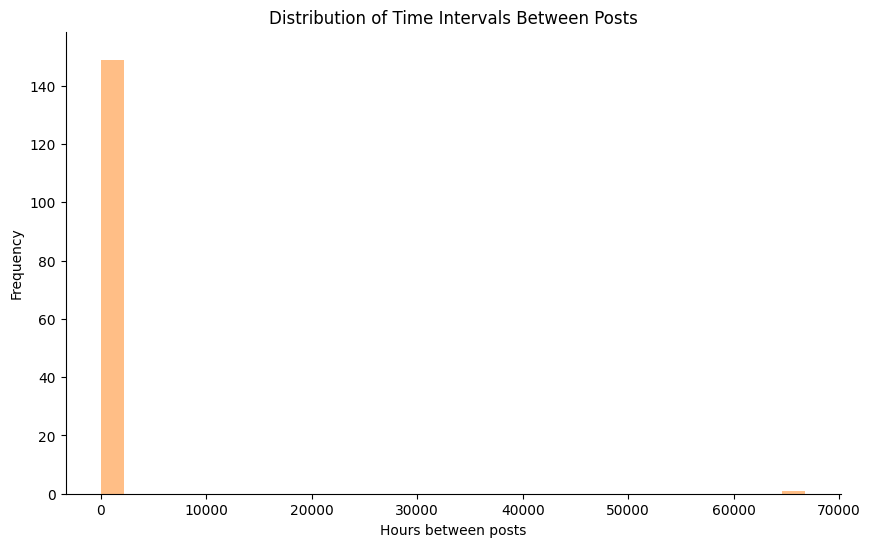

In [13]:
plt.figure(figsize=(10, 6))
for i in range(len(df_list)):
    df = df_list[i]

    print(f"Campaign: {CAMPAIGN_NAME[i]}")

    # Overall time intervals analysis
    print("=== OVERALL TIME INTERVALS ===")
    overall_intervals = basic.analyze_time_intervals(df, by_player=False)
    print(f"Mean interval: {overall_intervals['overall']['mean_hours']:.2f} hours")
    print(f"Median interval: {overall_intervals['overall']['median_hours']:.2f} hours")

    # Plot overall intervals
    intervals_data = overall_intervals['overall']['intervals_data']
    plt.hist(intervals_data, bins=30, alpha=0.5, edgecolor='none', linewidth=0.5)
    plt.title('Distribution of Time Intervals Between Posts')
    plt.xlabel('Hours between posts')
    plt.ylabel('Frequency')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    print('\n')


=== TIME INTERVALS BY PLAYER ===
LightSpeed: 20.62 hours (median: 9.32h, n=52)
AmazingAmazon: 24.87 hours (median: 12.37h, n=43)
ShyVideoGamer: 26.98 hours (median: 14.88h, n=40)
JacWalke: 25.82 hours (median: 15.78h, n=41)
Finny: 31.37 hours (median: 17.14h, n=34)
Saved: plots/time_intervals_by_player.png


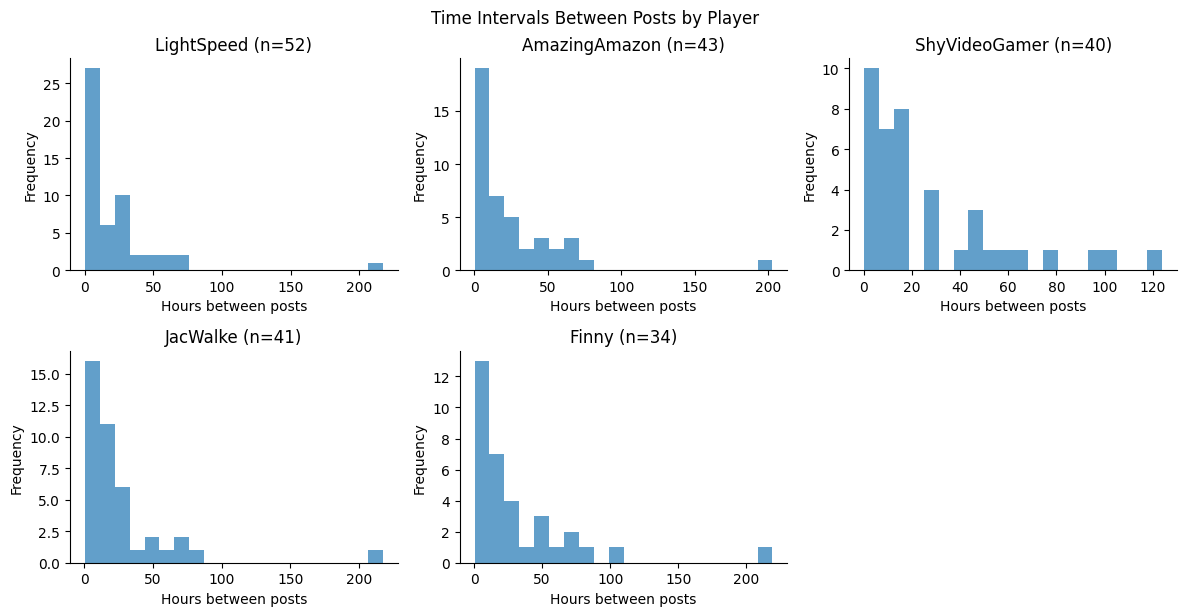

In [5]:
# Time intervals by player
print("\n=== TIME INTERVALS BY PLAYER ===")
player_intervals = basic.analyze_time_intervals(df, by_player=True)

# Print statistics for all players
for player, stats in player_intervals.items():
    print(f"{player}: {stats['mean_hours']:.2f} hours (median: {stats['median_hours']:.2f}h, n={stats['count']})")

# Plot intervals by player - create subplots based on number of players
if len(player_intervals) > 0:
    n_players = len(player_intervals)
    n_cols = min(3, n_players)  # Max 3 columns
    n_rows = (n_players + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_players == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_players > 1 else [axes]
    else:
        axes = axes.ravel()
    
    for i, (player, stats) in enumerate(player_intervals.items()):
        intervals_data = stats['intervals_data']
        axes[i].hist(intervals_data, bins=20, alpha=0.7, edgecolor='none', linewidth=0.5)
        axes[i].set_title(f'{player} (n={stats["count"]})')
        axes[i].set_xlabel('Hours between posts')
        axes[i].set_ylabel('Frequency')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    # Hide unused subplots
    for i in range(n_players, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Time Intervals Between Posts by Player', y=1.02)
    save_plot('time_intervals_by_player.png')
    plt.show()

## Cumulative Post Analysis

Track how posting activity accumulates over time, both overall and per player.

=== CUMULATIVE POSTS OVER TIME ===
Total posts in dataset: 216
Saved: plots/cumulative_posts_overall.png


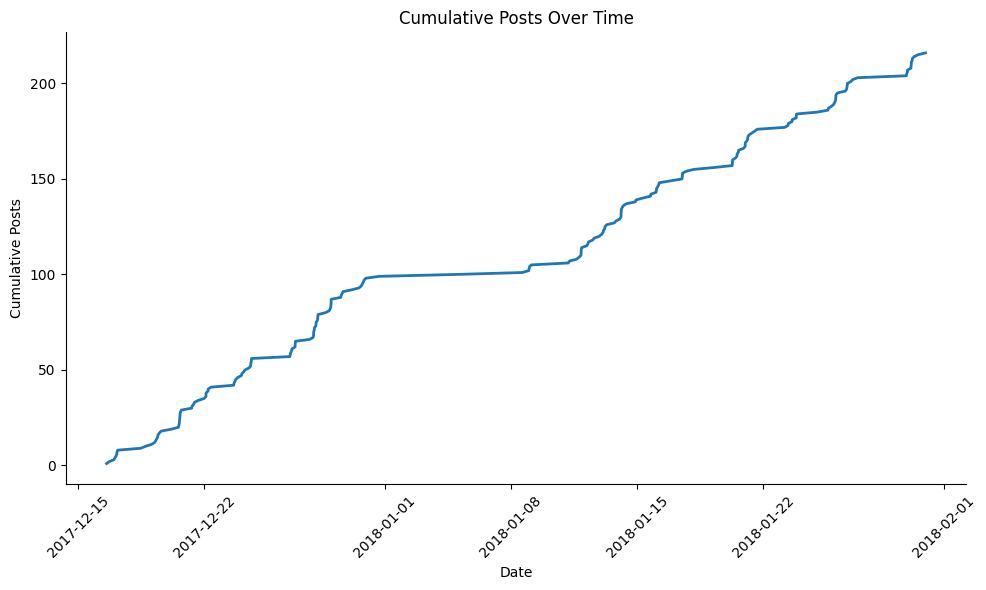

In [6]:
# Overall cumulative posts
print("=== CUMULATIVE POSTS OVER TIME ===")
cumulative_overall = basic.analyze_cumulative_posts(df, by_player=False)
print(f"Total posts in dataset: {len(cumulative_overall['cumulative_posts'])}")

# Plot overall cumulative posts
plt.figure(figsize=(10, 6))
plt.plot(cumulative_overall['dates'], cumulative_overall['cumulative_posts'], linewidth=2)
plt.title('Cumulative Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Posts')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot('cumulative_posts_overall.png')
plt.show()


=== CUMULATIVE POSTS BY PLAYER ===
Final post counts by player:
  LightSpeed: 53 posts
  AmazingAmazon: 44 posts
  JacWalke: 42 posts
  ShyVideoGamer: 41 posts
  Finny: 35 posts
Saved: plots/cumulative_posts_by_player.png


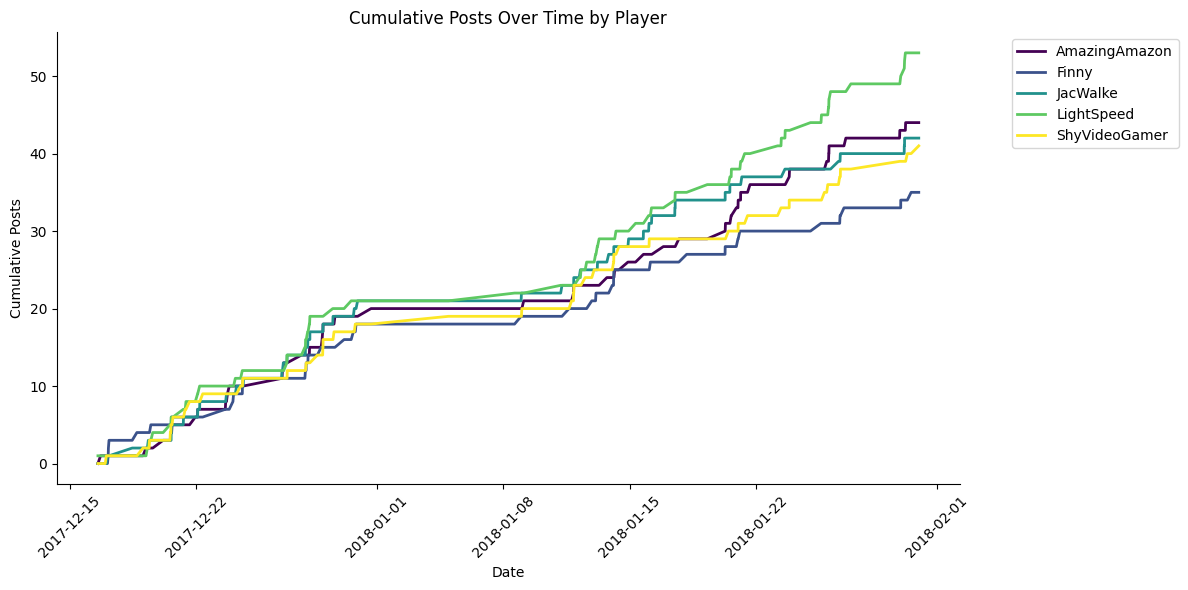

In [7]:
# Cumulative posts by player
print("\n=== CUMULATIVE POSTS BY PLAYER ===")
cumulative_by_player = basic.analyze_cumulative_posts(df, by_player=True)

if cumulative_by_player['type'] == 'by_player':
    # Print final counts
    final_counts = cumulative_by_player['data'].iloc[-1]
    print(f"Final post counts by player:")
    for player, count in final_counts.sort_values(ascending=False).head(10).items():
        print(f"  {player}: {count} posts")
    
    players      = cumulative_by_player['players']
    n_players    = len(players)
    cmap         = cm.get_cmap("viridis", n_players)          # perceptual colormap
    colours      = cmap(np.linspace(0, 1, n_players))         # N evenly-spaced colours

    # Plot cumulative posts by player
    plt.figure(figsize=(12, 6))
    for player in cumulative_by_player['players']:
        plt.plot(cumulative_by_player['dates'], cumulative_by_player['data'][player], 
                label=player, linewidth=2, color=colours[players.index(player)])
    
    plt.title('Cumulative Posts Over Time by Player')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Posts')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_plot('cumulative_posts_by_player.png')
    plt.show()

## Post Length Analysis

Examine the distribution of post lengths (word counts) to understand communication patterns.

=== OVERALL POST LENGTH STATISTICS ===
Mean words per post: 93.8
Median words per post: 53.5
Standard deviation: 117.8
Longest post: 1114 words
Saved: plots/post_lengths_overall.png


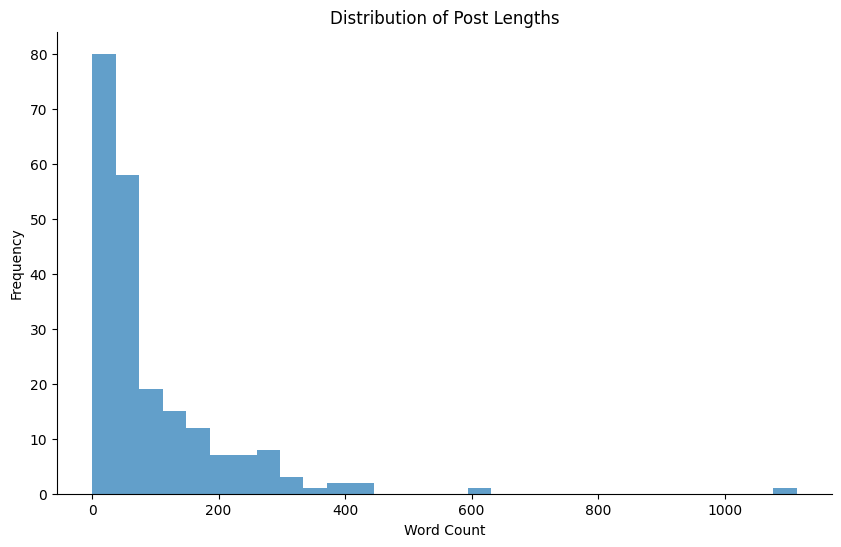

In [8]:
# Overall post length analysis
print("=== OVERALL POST LENGTH STATISTICS ===")
overall_lengths = basic.analyze_post_lengths(df, by_player=False)
stats = overall_lengths['overall']
print(f"Mean words per post: {stats['mean_words']:.1f}")
print(f"Median words per post: {stats['median_words']:.1f}")
print(f"Standard deviation: {stats['std_words']:.1f}")
print(f"Longest post: {stats['max_words']} words")

# Plot overall post lengths
plt.figure(figsize=(10, 6))
word_counts_data = stats['word_counts_data']
plt.hist(word_counts_data, bins=30, alpha=0.7, edgecolor='none', linewidth=0.5)
plt.title('Distribution of Post Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
save_plot('post_lengths_overall.png')
plt.show()


=== POST LENGTH BY ALL PLAYERS ===
LightSpeed: 147.7 words average (n=53)
AmazingAmazon: 60.3 words average (n=44)
fromshus: 149.0 words average (n=1)
ShyVideoGamer: 77.3 words average (n=41)
JacWalke: 93.6 words average (n=42)
Finny: 72.2 words average (n=35)
Saved: plots/post_lengths_by_player.png


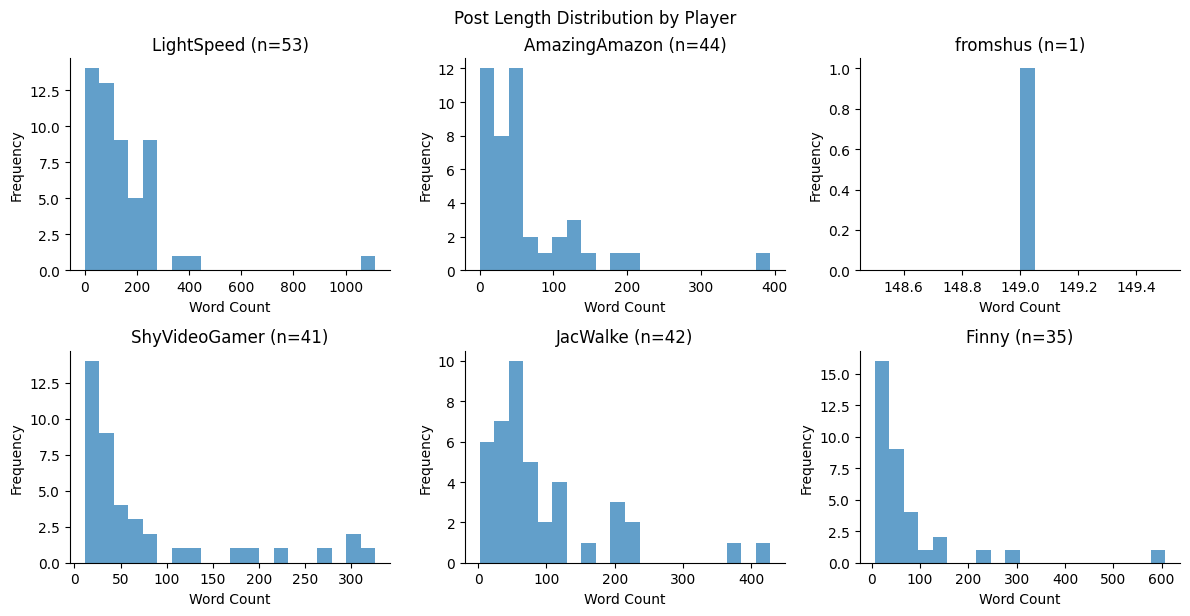

In [9]:
# Post length by player
print("\n=== POST LENGTH BY ALL PLAYERS ===")
player_lengths = basic.analyze_post_lengths(df, by_player=True)

# Print statistics for all players
for player, stats in player_lengths.items():
    if player != 'overall':
        print(f"{player}: {stats['mean_words']:.1f} words average (n={stats['count']})")

# Plot post lengths by player - create subplots based on number of players
if len(player_lengths) > 0:
    n_players = len(player_lengths)
    n_cols = min(3, n_players)  # Max 3 columns
    n_rows = (n_players + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_players == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_players > 1 else [axes]
    else:
        axes = axes.ravel()

    for i, (player, stats) in enumerate(player_lengths.items()):
        word_counts_data = stats['word_counts_data']
        axes[i].hist(word_counts_data, bins=20, alpha=0.7, edgecolor='none', linewidth=0.5)
        axes[i].set_title(f'{player} (n={stats["count"]})')
        axes[i].set_xlabel('Word Count')
        axes[i].set_ylabel('Frequency')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    # Hide unused subplots
    for i in range(n_players, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Post Length Distribution by Player', y=1.02)
    save_plot('post_lengths_by_player.png')
    plt.show()

## Summary Report {#summary}

Generate a comprehensive overview of the entire campaign for quick insights.

In [10]:
# Generate comprehensive summary report
print("=== COMPREHENSIVE CAMPAIGN SUMMARY ===")
summary = basic.generate_summary_report(df)

print("\n📊 CAMPAIGN OVERVIEW")
overview = summary['campaign_overview']
print(f"  📅 Duration: {overview['date_range']}")
print(f"  📝 Total posts: {overview['total_posts']}")
print(f"  👥 Unique players: {overview['unique_players']}")
print(f"  🎭 Unique characters: {overview['unique_characters']}")
print(f"  📈 Posts per day: {overview['posts_per_day']:.1f}")

print("\n📝 POSTING PATTERNS")
patterns = summary['posting_patterns']
print(f"  🏆 Most active player: {patterns['most_active_player']} ({patterns['posts_by_most_active']} posts)")
print(f"  📏 Average post length: {patterns['average_post_length']:.1f} words")
print(f"  📚 Longest post: {patterns['longest_post_words']} words")

print("\n🎮 GAMEPLAY CHARACTERISTICS")
gameplay = summary['gameplay_characteristics']
print(f"  🎲 Dice roll frequency: {gameplay['dice_roll_percentage']:.1f}%")
print(f"  ⚔️ Action posts: {gameplay['action_percentage']:.1f}%")
print(f"  💬 Dialogue posts: {gameplay['dialogue_percentage']:.1f}%")
print(f"  ⚔️ Combat posts: {gameplay['combat_posts']} ({gameplay['combat_percentage']:.1f}%)")

print("\n✅ Analysis complete! All plots have been saved as PNG files.")

=== COMPREHENSIVE CAMPAIGN SUMMARY ===

📊 CAMPAIGN OVERVIEW
  📅 Duration: 2017-12-16 to 2018-01-30
  📝 Total posts: 216
  👥 Unique players: 6
  🎭 Unique characters: 5
  📈 Posts per day: 4.8

📝 POSTING PATTERNS
  🏆 Most active player: LightSpeed (53 posts)
  📏 Average post length: 93.8 words
  📚 Longest post: 1114 words

🎮 GAMEPLAY CHARACTERISTICS
  🎲 Dice roll frequency: 6.0%
  ⚔️ Action posts: 52.8%
  💬 Dialogue posts: 27.3%
  ⚔️ Combat posts: 32 (14.8%)

✅ Analysis complete! All plots have been saved as PNG files.
